In [20]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy.optimize

from sublimpy import tidy


import altair as alt
alt.data_transformers.enable('json') 
import matplotlib.pyplot as plt

import xarray as xr

import pint_xarray
from metpy.calc import specific_humidity_from_mixing_ratio
from metpy.units import units

# Inputs

In [21]:
start_date = '20221130'
end_date = '20230509'
sos_download_dir = '/data2/elilouis/sublimationofsnow/sosnoqc'

In [22]:
try:
    tidy_df_5Min = pd.read_parquet(f"../sos/tidy_df_30Min_{start_date}_{end_date}_noplanar_fit.parquet")
except FileNotFoundError:
    print("No file such file exists for these dates.")
tidy_df_5Min['time'] = pd.to_datetime(tidy_df_5Min['time'])

# M.O.S.T. Solutions

## Extract variables, make necessary conversions, and create measurement height variable

In [23]:
# EXTRACT VARIABLES
VARIABLES = [
    ## Input Variables
    'spd_3m_c',
    'spd_5m_c',
    'Tpot_3m_c',
    'Tpot_5m_c',
    'Tsurfpot_rad_c',
    'airdensity_3m_c',
    'mixingratio_3m_c',
    'mixingratio_5m_c',
    'Tsurfmixingratio_rad_c',
    'T_3m_c',
    ## Measurement Variables
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_tc__3m_c',
    'u*_3m_c',
    'Ri_3m_c',
    ## Input Variables for Turbpy
    'Tsurf_rad_d',
    'P_10m_c',
]
print([ v for v in tidy_df_5Min.variable.unique() if v in VARIABLES ])

# CREATE DATAFRAME
variables_df = tidy_df_5Min[tidy_df_5Min.variable.isin(VARIABLES)].pivot_table(
    values = 'value',
    index = 'time',
    columns='variable'
).reset_index()

# MAKE CONVERSIONS
# convert from ˚C to K
variables_df['T_3m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['T_5m_c'] = variables_df['T_3m_c'] + 273.15
variables_df['Tpot_3m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tpot_5m_c'] = variables_df['Tpot_3m_c'] + 273.15
variables_df['Tsurfpot_rad_c'] = variables_df['Tsurfpot_rad_c'] + 273.15
variables_df['Tsurf_rad_d'] = variables_df['Tsurf_rad_d']  + 273.15
# comes in units of g/g
variables_df['specifichumidity_3m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_3m_c'])*units('g/g')
).pint.to('g/kg').values
variables_df['specifichumidity_5m_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['mixingratio_5m_c'])*units('g/g')
).pint.to('g/kg').values

# comes in units of g/g
# our solution requires it in units of g/kg
variables_df['specifichumidity_surface_c'] = specific_humidity_from_mixing_ratio(
    xr.DataArray(variables_df['Tsurfmixingratio_rad_c'])*units('g/g')
).pint.to('g/kg').values

# CREATE MEASUREMENT HEIGHT VARIABLES
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3
variables_df['measurement_height'] = 3

variables_df['measurement_height_2'] = 5
variables_df['measurement_height_2'] = 5
variables_df['measurement_height_2'] = 5

['airdensity_3m_c', 'Tsurfmixingratio_rad_c', 'mixingratio_3m_c', 'mixingratio_5m_c', 'Tpot_3m_c', 'Tpot_5m_c', 'P_10m_c', 'Ri_3m_c', 'u*_3m_c', 'Tsurfpot_rad_c', 'Tsurf_rad_d', 'T_3m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_tc__3m_c', 'spd_3m_c', 'spd_5m_c']


In [24]:
variables_df

variable,time,P_10m_c,Ri_3m_c,T_3m_c,Tpot_3m_c,Tpot_5m_c,Tsurf_rad_d,Tsurfmixingratio_rad_c,Tsurfpot_rad_c,airdensity_3m_c,...,u*_3m_c,w_h2o__3m_c,w_h2o__5m_c,w_tc__3m_c,T_5m_c,specifichumidity_3m_c,specifichumidity_5m_c,specifichumidity_surface_c,measurement_height,measurement_height_2
0,2022-11-29 17:00:00,713.159607,0.119395,260.352508,286.680558,559.830558,257.076847,0.001536,283.042939,0.954360,...,0.310110,0.001584,0.001981,-0.033430,533.502508,1.306591,1.195764,1.534056,3,5
1,2022-11-29 17:30:00,713.428101,0.116963,260.099139,286.370790,559.520790,254.252201,0.001207,279.902879,0.955830,...,0.398126,0.001530,0.001950,-0.073341,533.249139,0.994843,0.908878,1.205349,3,5
2,2022-11-29 18:00:00,714.011922,0.309685,259.767198,285.938493,559.088493,253.104264,0.001092,278.574006,0.957856,...,0.275483,-0.000297,-0.000398,-0.056730,532.917198,0.959287,0.884028,1.091130,3,5
3,2022-11-29 18:30:00,714.681264,2.038709,258.161803,284.095353,557.245353,250.783456,0.000893,275.945832,0.964693,...,0.214887,0.000404,0.000032,-0.001789,531.311803,1.017955,0.941282,0.891944,3,5
4,2022-11-29 19:00:00,715.163198,0.933350,256.820924,282.565278,555.715278,249.214067,0.000776,274.166134,0.970349,...,0.181955,-0.000359,-0.000467,-0.016223,529.970924,1.057715,0.976209,0.775037,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7594,2023-05-09 15:30:00,719.592316,0.903728,284.321712,312.271602,585.421602,277.832551,0.007452,305.111431,0.880965,...,0.349659,0.007196,0.009306,-0.023850,557.471712,2.841738,2.581181,7.396814,3,5
7595,2023-05-09 16:00:00,719.428986,0.099363,284.559379,312.552903,585.702903,277.770560,0.007421,305.063127,0.880004,...,0.376751,0.016461,0.018997,-0.070990,557.709379,2.888589,2.638205,7.366427,3,5
7596,2023-05-09 16:30:00,719.380747,0.223501,284.165380,312.126115,585.276115,277.713243,0.007392,305.006018,0.881061,...,0.220977,0.007976,0.008256,-0.038993,557.315380,3.085573,2.812845,7.337273,3,5
7597,2023-05-09 17:00:00,719.295563,0.233426,284.578926,312.590933,585.740933,277.589692,0.007328,304.880642,0.879727,...,0.329714,0.012381,0.010625,-0.056286,557.728926,2.990931,2.743027,7.274721,3,5


## Use MOST solver class

In [5]:
from most import MOST, MOSTMulti, StabilityFunctionBrutsaert1982
my_most = MOST(
    StabilityFunctionBrutsaert1982()
)

L_solutions, u_friction_solutions, H_solutions, E_solutions = my_most.solve(
    variables_df['spd_3m_c'],
    variables_df['Tpot_3m_c'],
    variables_df['Tsurfpot_rad_c'],
    variables_df['airdensity_3m_c'],
    variables_df['specifichumidity_3m_c'],
    variables_df['specifichumidity_surface_c'],
    variables_df['T_3m_c'],
    variables_df['measurement_height']
)

variables_df['L_solution'] = L_solutions
variables_df['u_friction_solution'] = u_friction_solutions
variables_df['H_solution'] = H_solutions
variables_df['E_solution'] = E_solutions

In [6]:
variables_df['E_solution'].head(50)

0     0.001813
1     0.002006
2     0.000987
3    -0.000149
4    -0.000247
5    -0.000307
6    -0.000385
7    -0.000391
8    -0.000363
9    -0.000365
10   -0.000312
11   -0.000254
12   -0.000327
13   -0.000395
14   -0.000311
15   -0.000224
16   -0.000067
17   -0.000162
18   -0.000209
19   -0.000210
20   -0.000019
21   -0.000132
22   -0.000077
23   -0.000186
24   -0.000211
25   -0.000272
26   -0.000239
27   -0.000310
28   -0.000303
29   -0.000175
30   -0.000086
31    0.000062
32    0.000605
33    0.002445
34    0.004249
35    0.005790
36    0.008147
37    0.010671
38    0.011770
39    0.011927
40    0.011484
41    0.009952
42    0.007176
43    0.000247
44   -0.000301
45   -0.000751
46   -0.000833
47   -0.000695
48   -0.000737
49   -0.000833
Name: E_solution, dtype: float64

In [7]:
variables_df[['spd_3m_c',
'Tpot_3m_c',
'Tsurfpot_rad_c',
'airdensity_3m_c',
'specifichumidity_3m_c',
'specifichumidity_surface_c',
'T_3m_c',
'measurement_height']]

variable,spd_3m_c,Tpot_3m_c,Tsurfpot_rad_c,airdensity_3m_c,specifichumidity_3m_c,specifichumidity_surface_c,T_3m_c,measurement_height
0,3.323426,286.680558,283.042939,0.954360,1.306591,1.534056,260.352508,3
1,4.556745,286.370790,279.902879,0.955830,0.994843,1.205349,260.099139,3
2,3.731591,285.938493,278.574006,0.957856,0.959287,1.091130,259.767198,3
3,1.838974,284.095353,275.945832,0.964693,1.017955,0.891944,258.161803,3
4,1.354227,282.565278,274.166134,0.970349,1.057715,0.775037,256.820924,3
...,...,...,...,...,...,...,...,...
7594,3.279272,312.271602,305.111431,0.880965,2.841738,7.396814,284.321712,3
7595,4.236264,312.552903,305.063127,0.880004,2.888589,7.366427,284.559379,3
7596,2.612355,312.126115,305.006018,0.881061,3.085573,7.337273,284.165380,3
7597,3.576606,312.590933,304.880642,0.879727,2.990931,7.274721,284.578926,3


In [8]:
my_most_multi = MOSTMulti(
    StabilityFunctionBrutsaert1982()
)
L_solutions_multi, u_friction_solutions_multi, H_solutions_multi, E_solutions_multi = my_most_multi.solve(
    variables_df['spd_3m_c'],
    variables_df['spd_5m_c'],
    variables_df['Tpot_3m_c'],
    variables_df['Tpot_5m_c'],
    variables_df['airdensity_3m_c'],
    variables_df['specifichumidity_3m_c'],
    variables_df['specifichumidity_5m_c'],
    variables_df['T_3m_c'],
    variables_df['measurement_height'],
    variables_df['measurement_height_2']
)



variables_df['L_solution_multi'] = L_solutions_multi
variables_df['u_friction_solution_multi'] = u_friction_solutions_multi
variables_df['H_solution_multi'] = H_solutions_multi
variables_df['E_solution_multi'] = E_solutions_multi

## Plot results

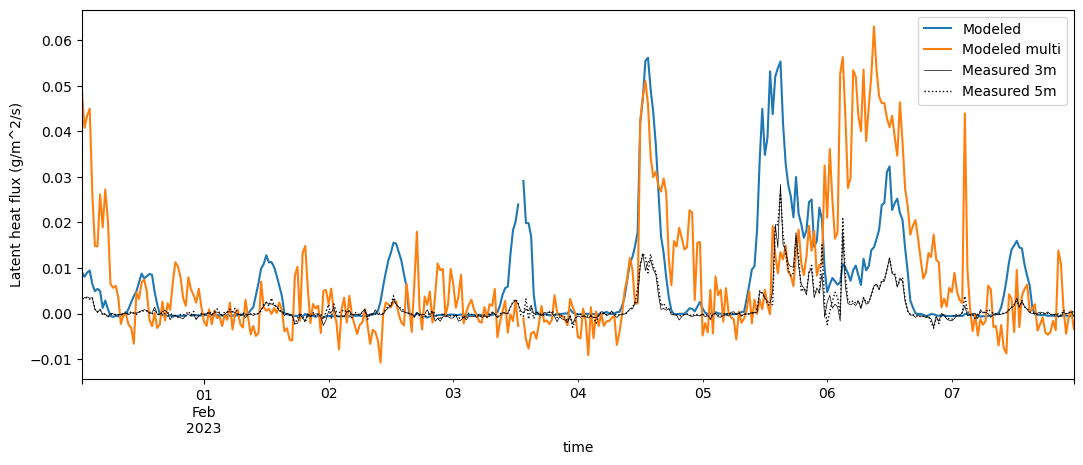

In [9]:
plt.figure(figsize=(2*6.4, 4.8))
src = variables_df[(variables_df.time > "2023-01-31") & (variables_df.time < "2023-02-08")]
src.plot(x='time', y='E_solution', label='Modeled', ax = plt.gca())
src.plot(x='time', y='E_solution_multi', label='Modeled multi', ax = plt.gca())
src.plot(x='time', y='w_h2o__3m_c', label='Measured 3m', color='black', linewidth=0.5, ax = plt.gca())
src.plot(x='time', y='w_h2o__5m_c', label='Measured 5m', color='black', linestyle=':', linewidth=1.0, ax = plt.gca())
# plt.ylim(-0.05, 0.05)
plt.ylabel("Latent heat flux (g/m^2/s)")
plt.legend()

In [10]:
variables_df['specifichumidity_grad'] = (variables_df['specifichumidity_3m_c'] - variables_df['specifichumidity_surface_c']) / 3

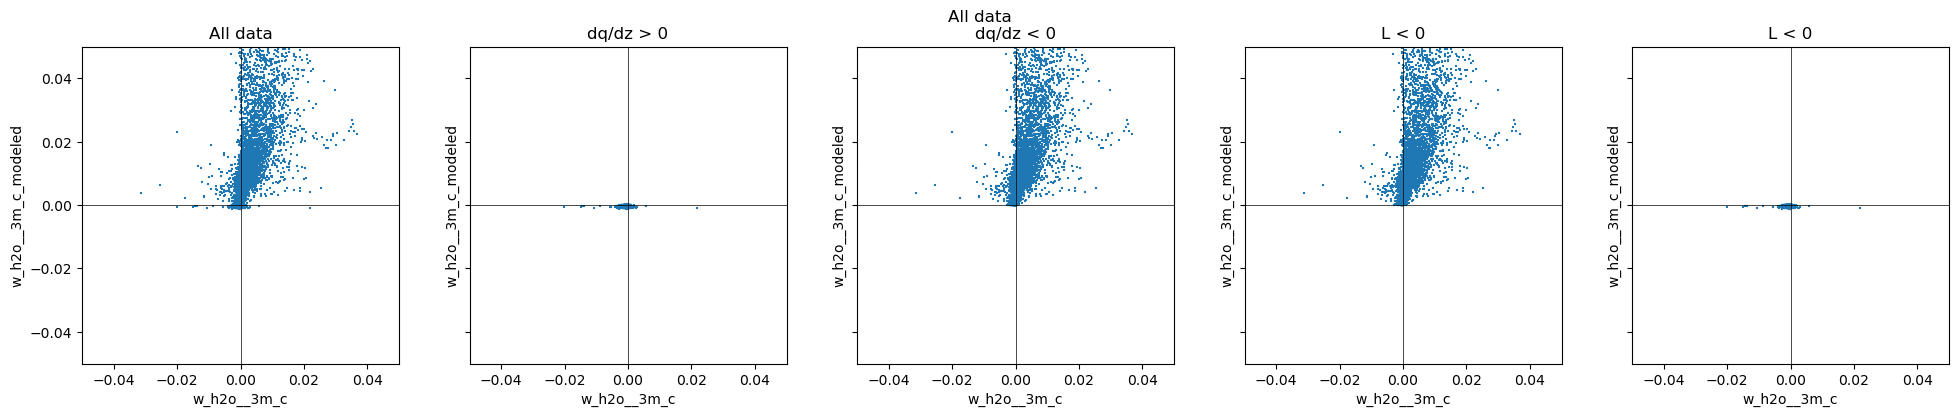

In [11]:
fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df['w_h2o__3m_c'], variables_df['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("All data")
plt.tight_layout()

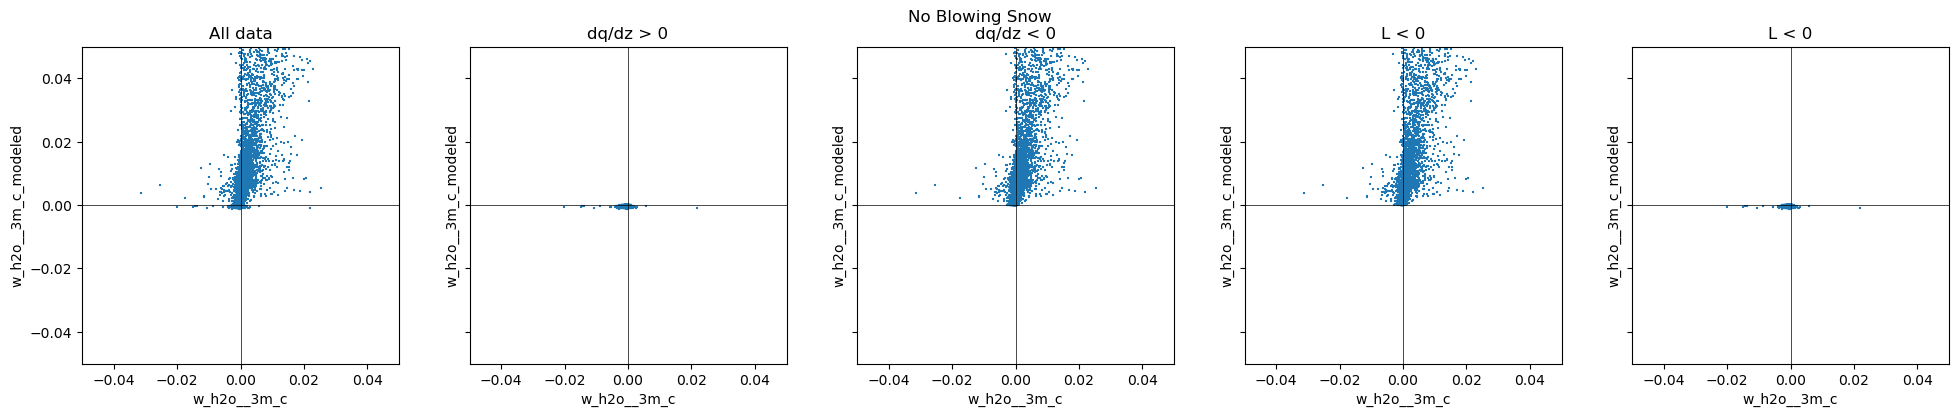

In [12]:
no_bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value == 0").time

variables_df_src = variables_df[variables_df.time.isin(no_bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("No Blowing Snow")
plt.tight_layout()

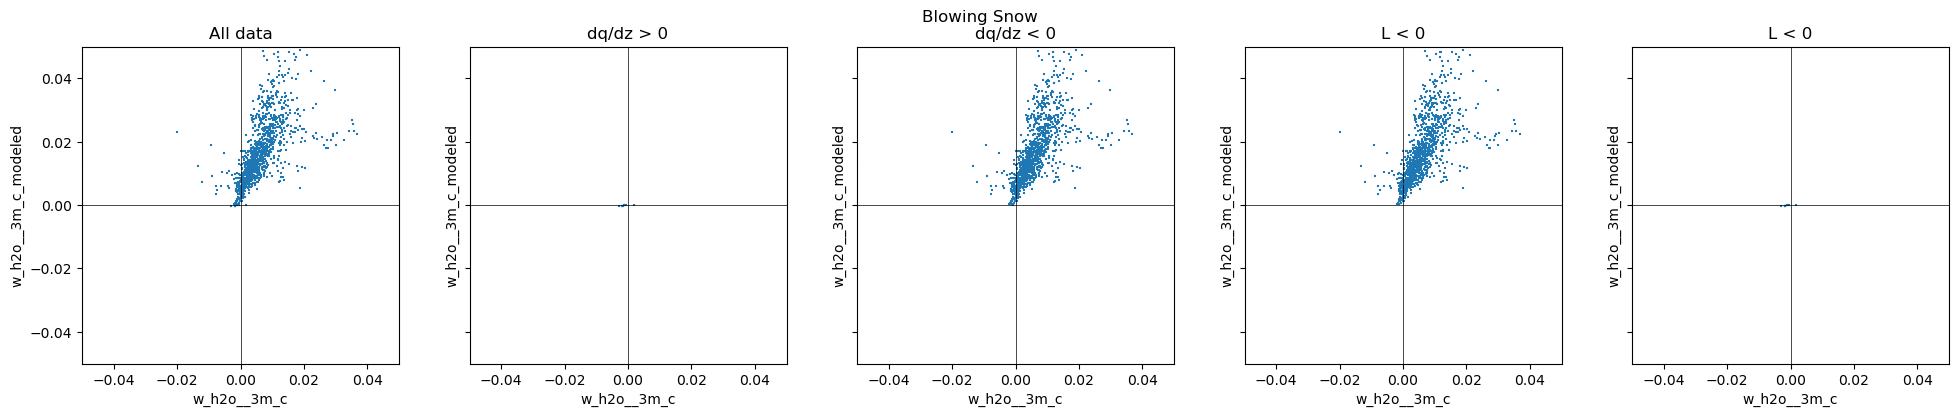

In [13]:
bs_times = tidy_df_5Min.query("variable == 'SF_avg_1m_ue'").query("value > 0").time

variables_df_src = variables_df[variables_df.time.isin(bs_times)]

fig, axes = plt.subplots(1,5, figsize=(20,4), sharex=True, sharey=True)

# all data
axes[0].set_title("All data")
axes[0].scatter(variables_df_src['w_h2o__3m_c'], variables_df_src['E_solution'], s=0.6, marker='+')

# dq/dz > 0 (expected downward motion of water vapor)
axes[1].set_title("dq/dz > 0")
src = variables_df_src.query("specifichumidity_grad > 0")
axes[1].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# dq/dz < 0 (expected upward motion of water vapor)
axes[2].set_title("dq/dz < 0")
src = variables_df_src.query("specifichumidity_grad < 0")
axes[2].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L < 0
axes[3].set_title("L < 0")
src = variables_df_src.query("L_solution < 0")
axes[3].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

# L > 0
axes[4].set_title("L < 0")
src = variables_df_src.query("L_solution > 0")
axes[4].scatter(src['w_h2o__3m_c'], src['E_solution'], s=0.6, marker='+')

for ax in axes:
    ax.set_xlabel('w_h2o__3m_c')
    ax.set_ylabel('w_h2o__3m_c_modeled')
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)
    ax.set_aspect('equal')
plt.suptitle("Blowing Snow")
plt.tight_layout()

# Use TurbPy

In [14]:
from metpy.units import units
import turbpy
import json
import copy

## Get TurbPy parameter schemes

This code for instantiating the TurbPy schemes was copied from the Turbpy example notebook  

https://github.com/klapo/turbpy/blob/master/TF.turbpyDemonstration.ipynb

In [15]:
scheme_dict_1 = {
    'MO (Holtslag/de Bruin)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'holtslag_debruin'
            }
        },
    
}
scheme_dict_2 = {
    # 'MO (Webb)': {
    #         'stability_method': 'monin_obukhov',
    #         'monin_obukhov': {
    #             'gradient_function': 'webb'
    #         },
    #         'stability_params': {
    #             'webb': 5.2
    #         }
    # },
    'MO (Webb NoahMP)': {
            'stability_method': 'monin_obukhov',
            'monin_obukhov': {
                'gradient_function': 'webb_noahmp'
            },
            'stability_params': {
                'webb': 5.2
            }
    },
    # 'MO (Marks-Dozier)': {
    #         'stability_method': 'monin_obukhov',
    #         'monin_obukhov': {
    #             'gradient_function': 'marks_dozier'
    #         },
    #         'stability_params': {
    #             'marks_dozier': 5.2
    #         }
    # }
}

## Retrieve our input measurements and convert to units required by TurbPy

In [16]:
SNOW_SURFACE_ROUGHNESS = 1e-4
height = 3
snowDepth = 0
fillna_method='ffill'

# collect inputs
sfcTemp = variables_df['Tsurf_rad_d']
airTemp = variables_df['T_3m_c']
windspd = variables_df['spd_3m_c']
airPressure = (variables_df['P_10m_c'].values * units.millibar).to(units.pascal).magnitude

# the turbpy.vapPress function requires specific humidity in units of g/g
specific_humidity = xr.DataArray(variables_df['specifichumidity_3m_c'])*units('g/kg').to('g/g').magnitude

airVaporPress = turbpy.vapPress(
    specific_humidity,
    airPressure
)

# requires temp in units ˚C
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.15)

In [17]:
variables_df[['Tsurf_rad_d',
'T_3m_c',
'spd_3m_c',
'P_10m_c',
'mixingratio_3m_c',]]

variable,Tsurf_rad_d,T_3m_c,spd_3m_c,P_10m_c,mixingratio_3m_c
0,257.076847,260.352508,3.323426,713.159607,0.001308
1,254.252201,260.099139,4.556745,713.428101,0.000996
2,253.104264,259.767198,3.731591,714.011922,0.000960
3,250.783456,258.161803,1.838974,714.681264,0.001019
4,249.214067,256.820924,1.354227,715.163198,0.001059
...,...,...,...,...,...
7594,277.832551,284.321712,3.279272,719.592316,0.002850
7595,277.770560,284.559379,4.236264,719.428986,0.002897
7596,277.713243,284.165380,2.612355,719.380747,0.003095
7597,277.589692,284.578926,3.576606,719.295563,0.003000


## Run the calculations

In [18]:

## Calculate stability
# Initialzie dictionaries for containing output
stability_correction = {}
conductance_sensible = {}
conductance_latent = {}
sensible_heat = {}
latent_heat = {}
zeta = {}

for scheme in [scheme_dict_1, scheme_dict_2]:
    for stab in scheme.keys():
        stability_correction[stab] = np.zeros_like(sfcTemp)
        conductance_sensible[stab] = np.zeros_like(sfcTemp)
        conductance_latent[stab] = np.zeros_like(sfcTemp)
        sensible_heat[stab] = np.zeros_like(sfcTemp)
        latent_heat[stab] = np.zeros_like(sfcTemp)
        zeta[stab] = np.zeros_like(sfcTemp)

    ## Calculate stability
    for stab in scheme.keys():
        for n, (tair, vpair, tsfc, vpsfc, u, airP) in enumerate(zip(
            airTemp, airVaporPress, sfcTemp, sfcVaporPress, windspd, airPressure
        )):
            if any(np.isnan([tair, vpair, tsfc, vpsfc, u, airP])):
                stability_correction[stab][n] = np.nan
                conductance_sensible[stab][n] = np.nan
                conductance_latent[stab][n] = np.nan
                sensible_heat[stab][n] = np.nan
                latent_heat[stab][n] = np.nan
                zeta[stab][n] = np.nan
            else:
                (
                    conductance_sensible[stab][n], 
                    conductance_latent[stab][n], 
                    sensible_heat[stab][n],
                    latent_heat[stab][n],
                    stab_output,
                    p_test
                ) = turbpy.turbFluxes(tair, airP,
                                                        vpair, u, tsfc,
                                                        vpsfc, snowDepth,
                                                        height, param_dict=scheme[stab],
                                                        z0Ground=SNOW_SURFACE_ROUGHNESS, groundSnowFraction=1)
                # Get the Zeta value from the stability parameters dictionary
                if scheme[stab]['stability_method'] != 'monin_obukhov':
                    stability_correction[stab][n] = stab_output['stabilityCorrection']
                    # SHOULD I JUST BE ASSIGNING NAN HERE?
                    zeta[stab][n] = stab_output['zeta']
                else:
                    stability_correction[stab][n] = np.nan
                    zeta[stab][n] = stab_output['zeta']

KeyboardInterrupt: 

## Create dataframe with the Turbpy results, our iterative solution results, and our measurement dataset

In [ ]:
for key in stability_correction.keys():
    variables_df[f'latent_heat_flux {key}'] = -latent_heat[key]/2838
    variables_df[f'sensible_heat_flux {key}'] = -sensible_heat[key]
    variables_df[f'obukhov_length {key}'] = 3 / zeta[key]

In [ ]:
variables_df

## Plot results

In [ ]:
method_names = list(scheme_dict_1.keys()) + list(scheme_dict_2.keys())
method_names

In [ ]:
import itertools
from sklearn.metrics import r2_score

In [ ]:
for (x,y) in list(itertools.combinations(method_names, 2)):
    print(x)
    print(y)
    print(r2_score(variables_df.dropna()[f'latent_heat_flux {x}'],    variables_df.dropna()[f'latent_heat_flux {y}']))
    print()

In [ ]:

src = variables_df[(variables_df.time > '2022-12-24') & (variables_df.time < '2022-12-26')]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', 'E_solution']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', 'E_solution']].dropna()[f'E_solution']) 
print("Our solution")
print(r_value**2)
print(np.mean(src['E_solution'] - src['w_h2o__3m_c']))
print()

for x in method_names:
    print(x)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()['w_h2o__3m_c'], src[['w_h2o__3m_c', f'latent_heat_flux {x}']].dropna()[f'latent_heat_flux {x}']) 
    print(r_value**2)
    print(np.mean(src[f'latent_heat_flux {x}'] - src['w_h2o__3m_c']))
    print()

In [ ]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(src.dropna()['w_h2o__3m_c'], src.dropna()[f'E_solution'])
r_value**2, p_value

In [ ]:
r_value**2, p_value

In [ ]:
variables_df['zeta_solution'] = 3 / variables_df['L_solution']
variables_df['zeta MO (Marks-Dozier)'] = 3 / variables_df['obukhov_length MO (Marks-Dozier)']

In [ ]:
def stability_regime_from_zeta(zeta):
    if np.isnan(zeta):
        return np.nan
    if zeta < -0.01:
        return "unstable"
    elif zeta > -0.01 and zeta < 0.01:
        return "neutral"
    elif zeta > 0.01 and zeta <= 1:
        return "stable"
    elif zeta > 1:
        return "very stable"
    else:
        print("WTF?")
        return np.nan
variables_df['stability regime'] = variables_df['zeta_solution'].apply(stability_regime_from_zeta)
variables_df['stability regime (turbpy)'] = variables_df['zeta MO (Marks-Dozier)'].apply(stability_regime_from_zeta)

In [ ]:
variables_df['end_time'] = variables_df['time'] + dt.timedelta(minutes=30)
unstable_times = variables_df[variables_df['stability regime'] == 'unstable']
neutral_times = variables_df[variables_df['stability regime'] == 'neutral']
stable_times = variables_df[variables_df['stability regime'] == 'stable']
v_stable_times = variables_df[variables_df['stability regime'] == 'very stable']

In [ ]:
plt.scatter(variables_df['zeta MO (Marks-Dozier)'], variables_df['Ri_3m_c'], s=0.1),
plt.axhline(0)
plt.axvline(0)
plt.ylim(-5, 5)
plt.xlim(-50, 50)

In [ ]:
plt.scatter(variables_df['zeta_solution'], variables_df['Ri_3m_c'])

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='yellow', alpha=0.1, label='unstable')
    if row['stability regime'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='grey', alpha=0.2, label='neutral')
    if row['stability regime'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='teal', alpha=0.2, label='stable')
    if row['stability regime'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='blue', alpha=0.2, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_h2o__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'E_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'latent_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime (turbpy)'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='black', alpha=0.25, label='unstable')
    if row['stability regime (turbpy)'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='darkgrey', alpha=0.75, label='neutral')
    if row['stability regime (turbpy)'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='lightgrey', alpha=0.5, label='stable')
    if row['stability regime (turbpy)'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='white', alpha=0.5, label='very stable')


plt.ylabel("Latent heat fluxes (g/m^2/s)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]
# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'w_tc__3m_c',                         label = 'Measured',                             color='black',  linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'H_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'sensible_heat_flux MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)

for i, row in variables_df.iterrows():
    if row['stability regime (turbpy)'] == 'unstable':
        plt.gca().axvspan(row['time'], row['end_time'], color='black', alpha=0.25, label='unstable')
    if row['stability regime (turbpy)'] == 'neutral':
        plt.gca().axvspan(row['time'], row['end_time'], color='darkgrey', alpha=0.75, label='neutral')
    if row['stability regime (turbpy)'] == 'stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='lightgrey', alpha=0.5, label='stable')
    if row['stability regime (turbpy)'] == 'very stable':
        plt.gca().axvspan(row['time'], row['end_time'], color='white', alpha=0.5, label='very stable')


plt.ylabel("Sensible heat fluxes (W/m^2)")

In [ ]:
src = variables_df[(variables_df.time > '2022-12-14') & (variables_df.time < '2022-12-28')]



# src = variables_df
plt.figure(figsize=(12.4, 4.8))
src.plot(x = 'time', y = 'zeta_solution',                          label = 'Iterative MOST (Marks-Dozier)',        color='blue',   linewidth=1.0, ax = plt.gca())
src.plot(x = 'time', y = 'zeta MO (Marks-Dozier)',  label = 'TurbPy MOST (Marks-Dozier), β = 5.2',  color='red',  linewidth=1.0, ax = plt.gca())
# src.plot(x = 'time', y = 'latent_heat_flux MO (Webb NoahMP)',   label = 'TurbPy MOST (Webb NoahMP), β = 5.2',   color='red',    linewidth=1.0, ax = plt.gca())
# plt.gca().axhline(0)
plt.ylabel("Obukhov length")
# plt.ylim(-250,250)
plt.yscale('symlog')

plt.axhline(0)
plt.axhline(1)
plt.axhline(-1)